In [1]:
#!pip install --upgrade ipywidgets
#!pip install --upgrade tqdm

In [2]:
import torch
import numpy as np

# version and gpu
print(torch.__version__)
print(torch.cuda.is_available())

# add gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

2.2.1+cu121
True
cuda


In [3]:
# load data 
# Load data
data_paths = [
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy",
    "/home/vm/Joao/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"
]

manta, xiris, y, feats = [np.load(path) for path in data_paths]
print("manta shape:", manta.shape)
print("xiris shape:", xiris.shape)
print("y shape:", y.shape)
print("feats shape:", feats.shape)

manta shape: (9587, 320, 320)
xiris shape: (9587, 320, 320)
y shape: (9587, 2)
feats shape: (9587, 8)


In [4]:
# expand dimensions
manta = np.expand_dims(manta, axis=1)
xiris = np.expand_dims(xiris, axis=1)

print("manta shape:", manta.shape)

# create X that concatnates manta and xiris where manta is the first channel and xiris is the second an manta again in 3rd channel
X = np.concatenate((manta, xiris, manta), axis=1)
print("X shape:", X.shape) # (n_samples, n_channels, height, width)

manta shape: (9587, 1, 320, 320)
X shape: (9587, 3, 320, 320)


In [5]:
# lenght and height -> y
# Get max of each column and normalize
y = feats[:, 1:3]
max_y = np.max(y, axis=0)
y = y / max_y

print("y shape:", y.shape)
print("y max:", max_y)

y shape: (9587, 2)
y max: [225. 158.]


In [6]:
from sklearn.model_selection import train_test_split

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

del X, y, manta, xiris, feats

In [140]:
BATCH_SIZE = 32
# create a dataloader and transfor the data (resize to target size of 224x224)
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# img = transform.resize(image, (new_h, new_w))

# apply data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(20),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# create dataset
class CustomDataset(TensorDataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
        # convert to tensor
        self.X = torch.tensor(self.X, dtype=torch.float32).to(device)
        self.y = torch.tensor(self.y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]

        if self.transform:
            sample = self.transform(sample)
        # make sure the sample is between 0 and 1
        sample = torch.clamp(sample, 0, 1)

        return sample, label
    
# create dataloaders
train_dataset = CustomDataset(X_train, y_train, transform_train)
val_dataset = CustomDataset(X_val, y_val, transform_test)
test_dataset = CustomDataset(X_test, y_test, transform_test)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#del X_train, X_val, X_test, y_train, y_val, y_test

Image shape: torch.Size([3, 224, 224])
Max val: 0.7233163118362427
Min: 0.0023361106868833303
tensor([[0.0065, 0.0112, 0.0078,  ..., 0.0085, 0.0076, 0.0092],
        [0.0066, 0.0098, 0.0108,  ..., 0.0088, 0.0099, 0.0115],
        [0.0124, 0.0072, 0.0062,  ..., 0.0117, 0.0097, 0.0057],
        ...,
        [0.0086, 0.0088, 0.0092,  ..., 0.0385, 0.0439, 0.0486],
        [0.0098, 0.0070, 0.0069,  ..., 0.0401, 0.0461, 0.0485],
        [0.0075, 0.0132, 0.0132,  ..., 0.0442, 0.0489, 0.0543]])


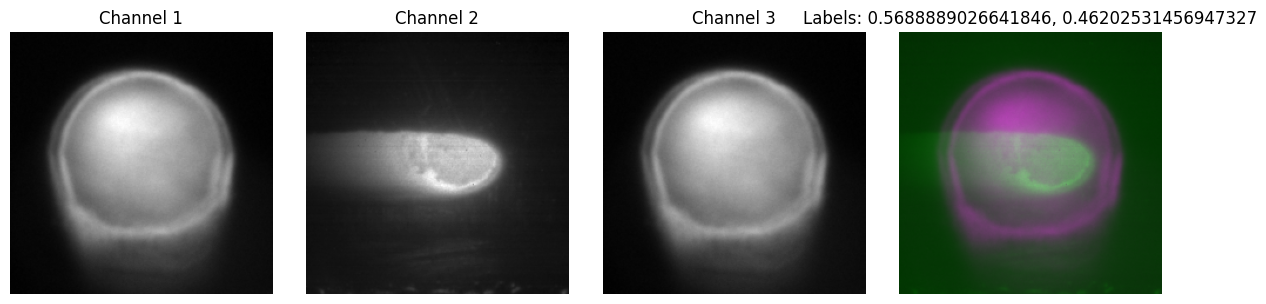

In [142]:
import matplotlib.pyplot as plt

# Function to visualize images from DataLoader
def visualize_single_image(dataloader):
    # Get a batch of data
    batch = next(iter(dataloader))
    images, labels = batch 
    
    # Get the first image
    img = images[0]
    
    # get to cpu
    img = img.cpu()
    # print shape
    print("Image shape:", img.shape)
    
    # Print max and min values for each channel in the current image
    print("Max val:", torch.max(img).item())
    print("Min:",  torch.min(img).item())

    # Convert to numpy array
    #img = img.numpy()
    print(img[0])
    
    # Plot the image
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for j in range(3):  # Plot each channel separately
        axes[j].imshow(img[j], cmap='gray')
        axes[j].set_title(f"Channel {j+1}")
        axes[j].axis('off')
    # Plot the combined image
    combined_img = np.transpose(img, (1,2,0))
    axes[3].imshow(combined_img)
    label_text = f"Labels: {', '.join([str(label.item()) for label in labels[0]])}"
    axes[3].set_title(label_text)
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()
    

# Visualize one image from training DataLoader
visualize_single_image(train_dataloader)

# Function to visualize images from DataLoader
def visualize_multiple_images(dataloader, num_images=2):
    # Get a batch of data
    batch = next(iter(dataloader))
    images, labels = batch
    
    # Plot the images
    fig, axes = plt.subplots(num_images, 4, figsize=(12, 6))
    for i in range(num_images):
        img = images[i]  # Fetch the image
        # get to cpu
        img = img.cpu()
        for j in range(3):  # Plot each channel separately
            axes[i, j].imshow(img[j], cmap='gray')
            axes[i, j].set_title(f"Channel {j+1}")
            axes[i, j].axis('off')
        # Plot the combined image
        combined_img = np.transpose(img, (1,2,0))
        axes[i, 3].imshow(combined_img)
        label_text = f"Labels: {', '.join([str(label.item()) for label in labels[i]])}"
        axes[i, 3].set_title(label_text)
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize images from training DataLoader
#visualize_multiple_images(train_loader, num_images=2)
# Visualize images from testing DataLoader
# visualize_multiple_images(dataloader_test, num_images=2)



In [9]:
from torch import nn
import torch.nn.functional as F

# Define the model

class SimpleCNN_reg(nn.Module):
    def __init__(self):
        super(SimpleCNN_reg, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 4 channels -> 3 channels + batch size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*28*28, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Create the model
model = SimpleCNN_reg()
print(model)   

SimpleCNN_reg(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [151]:
from transformers import AutoImageProcessor, ViTModel

#image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
base_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k", do_rescale=False, do_resize=True, do_normalize=True)
#image_processor


In [160]:
# Get a single batch of data
images, labels = next(iter(train_dataloader))

# Preprocess the data using the image processor (if needed)
#if image_processor.do_normalize:
images = image_processor(images, return_tensors="pt")

# Pass the data through the model
with torch.no_grad():  # Disable gradient calculation for testing
    outputs = base_model(**images)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

[32, 197, 768]

In [161]:
images

{'pixel_values': tensor([[[[-0.9843, -0.9843, -0.9843,  ..., -0.9765, -0.9843, -0.9765],
          [-0.9922, -0.9843, -0.9843,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9843, -0.9843, -0.9922,  ..., -0.9922, -0.9922, -0.9843],
          ...,
          [-0.9922, -0.9922, -0.9922,  ..., -0.8980, -0.8902, -0.8824],
          [-0.9922, -0.9843, -0.9922,  ..., -0.8980, -0.8902, -0.8824],
          [-0.9843, -0.9765, -0.9922,  ..., -0.8902, -0.8824, -0.8824]],

         [[-0.6157, -0.6157, -0.6078,  ..., -0.6314, -0.6235, -0.6235],
          [-0.6157, -0.6235, -0.6157,  ..., -0.6235, -0.6235, -0.6157],
          [-0.6157, -0.6157, -0.6235,  ..., -0.6314, -0.6235, -0.6157],
          ...,
          [-0.5765, -0.5765, -0.5765,  ..., -0.5765, -0.5765, -0.5765],
          [-0.5765, -0.5765, -0.5765,  ..., -0.5922, -0.5765, -0.5765],
          [-0.5765, -0.5765, -0.5765,  ..., -0.5843, -0.5843, -0.5765]],

         [[-0.9843, -0.9843, -0.9843,  ..., -0.9765, -0.9843, -0.9765],
          [-0

In [168]:
from torch import nn
import torch.nn.functional as F

# create a model that uses the image processor and the base model
class LMD_ViT(nn.Module):
    def __init__(self, image_processor, base_model):
        super(LMD_ViT, self).__init__()
        self.image_processor = image_processor
        self.base_model = base_model
        self.fc = nn.Linear(768, 2) # 768 is the output size of the base model

    def forward(self, data):
        images = self.image_processor(data, return_tensors="pt")
        output = self.base_model(**images)
        output = self.fc(output.last_hidden_state[:, 0, :])
        return output
    
# Create the model
model = LMD_ViT(image_processor, base_model)
print(model)

LMD_ViT(
  (base_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [183]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [184]:
model.to(device)

print(model.device)

AttributeError: 'LMD_ViT' object has no attribute 'device'

In [181]:
print(model.device)

AttributeError: 'LMD_ViT' object has no attribute 'device'

In [185]:
data, labels = next(iter(train_dataloader))

model.to(device)  # Move model to GPU
data = data.to(device)   # Move input to GPU

with torch.no_grad():
    outputs = model(data)
outputs


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [177]:
data, labels = next(iter(train_dataloader))

model = model.to(device)
data = data.to(device)

# Pass the data through the model
with torch.no_grad():  # Disable gradient calculation for testing
    outputs = model(data)
outputs


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [173]:
model.cpu()
# Get a batch of data
data, labels = next(iter(train_dataloader))
# Pass the data through the model
with torch.no_grad():  # Disable gradient calculation for testing
    outputs = model(data)
outputs


tensor([[ 0.0895,  0.1674],
        [ 0.0819,  0.1459],
        [ 0.1105,  0.1728],
        [ 0.1466,  0.1751],
        [ 0.1340,  0.1233],
        [ 0.0859,  0.1866],
        [ 0.0721,  0.1626],
        [ 0.1205,  0.1903],
        [ 0.0744,  0.0612],
        [-0.0172, -0.0010],
        [ 0.1124,  0.1808],
        [ 0.0251,  0.1497],
        [-0.0296,  0.0070],
        [ 0.1267,  0.2088],
        [ 0.0276, -0.0787],
        [ 0.1020,  0.1685],
        [ 0.0971,  0.1401],
        [ 0.0806,  0.0603],
        [ 0.1320,  0.0897],
        [ 0.0162,  0.1538],
        [-0.0647, -0.0807],
        [ 0.1282,  0.1364],
        [-0.1070,  0.1516],
        [ 0.0383,  0.1326],
        [ 0.1034,  0.1118],
        [ 0.1526,  0.1247],
        [ 0.1324,  0.1256],
        [ 0.0246, -0.0347],
        [ 0.1173,  0.1639],
        [ 0.1048,  0.1328],
        [ 0.0308,  0.1261],
        [ 0.1025,  0.1873]])

In [189]:
from tqdm import tqdm 

# Assuming 'model' is already defined and needs to be moved to the appropriate device
model.to('cuda')

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model
n_epochs = 5
train_losses = []
val_losses = []
len_train_loader = len(train_dataloader)
len_val_loader = len(val_dataloader)

for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0.0
    # Wrap the training data loader with tqdm
    for i, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')):
        images, labels = batch
        
        # prind images device
        print(images.device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len_train_loader
    train_losses.append(train_loss)
    
    # Evaluation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to track gradients during validation
        # Wrap the testing data loader with tqdm
        for batch in tqdm(val_dataloader, desc='Validation'):
            images, labels = batch# Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len_val_loader
    val_losses.append(val_loss)
    
    # Print training and validation information
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Optionally save the trained model
#torch.save(model.state_dict(), 'trained_model.pth')


Epoch 1/5:   0%|          | 0/192 [00:00<?, ?it/s]

cuda:0


Epoch 1/5:   0%|          | 0/192 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

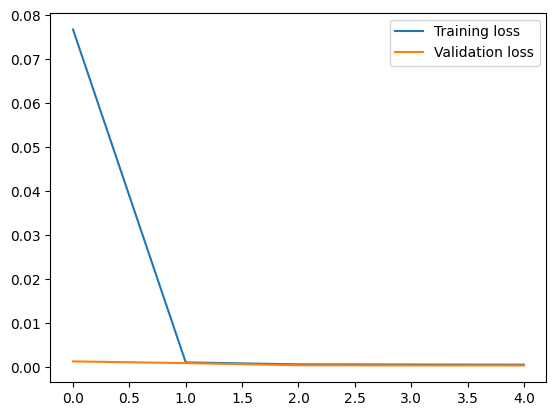

In [ ]:
# plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()


Validation: 100%|██████████| 60/60 [00:00<00:00, 155.52it/s]


Mean Squared Error: 0.0003


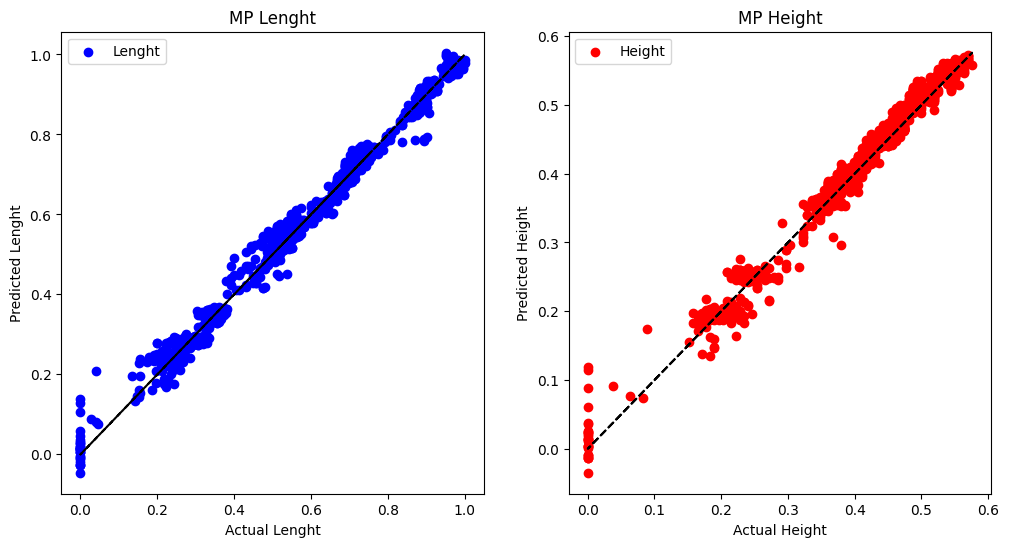

In [ ]:
# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predicted and actual labels
predicted_labels = []
actual_labels = []

# No need to track gradients during validation
with torch.no_grad():
    # Iterate over the test DataLoader
    for batch in tqdm(test_dataloader, desc='Validation'):
        images, labels = batch # Move data to GPU
        outputs = model(images)
        predicted_labels.append(outputs.cpu())  # Move predictions to CPU
        actual_labels.append(labels.cpu())  # Move actual labels to CPU

# Concatenate the lists to obtain the predicted and actual labels
predicted_labels = torch.cat(predicted_labels)
actual_labels = torch.cat(actual_labels)

# Calculate the mean squared error
mse = nn.MSELoss()
loss = mse(predicted_labels, actual_labels)
print(f"Mean Squared Error: {loss.item():.4f}")

# Plot the predicted and actual labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(actual_labels[:, 0], predicted_labels[:, 0], label='Lenght', color='blue')
plt.plot(actual_labels[:, 0], actual_labels[:, 0], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Lenght')
plt.ylabel('Predicted Lenght')
plt.title('MP Lenght')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(actual_labels[:, 1], predicted_labels[:, 1], label='Height', color='red')
plt.plot(actual_labels[:, 1], actual_labels[:, 1], color='black', linestyle='--')  # Identity line
plt.xlabel('Actual Height')
plt.ylabel('Predicted Height')
plt.title('MP Height')
plt.legend()

#plt.tight_layout()
plt.show()


In [ ]:
# print layer names 
for name, param in model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([32, 3, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 3, 3])
conv3.bias torch.Size([128])
fc1.weight torch.Size([512, 100352])
fc1.bias torch.Size([512])
fc2.weight torch.Size([2, 512])
fc2.bias torch.Size([2])


In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.fc1.register_forward_hook(get_activation('fc1'))

# Set the model to evaluation mode
model.eval()
batch = next(iter(test_dataloader))
images, labels = batch

# Forward pass
output = model(images)
print(activation['fc1'].shape)



torch.Size([32, 512])


In [ ]:
# Step 1: Iterate through all batches in the test_dataloader
activations = []
labels_list = []
with torch.no_grad():
    for batch in test_dataloader:
        images, labels = batch
        # Step 2: Forward pass
        output = model(images)
        # Step 3: Retrieve activations
        activations.append(activation['fc1'].cpu().numpy())
        labels_list.append(labels.cpu().numpy())  # Move labels to CPU before converting to numpy

# Step 4: Concatenate activations
activations = np.concatenate(activations)
labels_list = np.concatenate(labels_list)

# print shapes
print(activations.shape)
print(labels_list.shape)

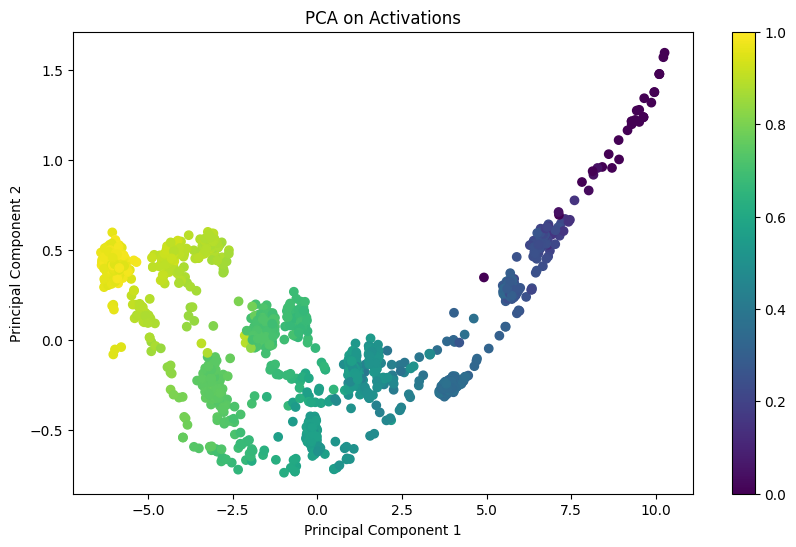

In [ ]:
# Perform PCA
from sklearn.decomposition import PCA

# Create PCA instance
pca = PCA(n_components=2)

# Fit PCA to your activations data
pca_result = pca.fit_transform(activations)

# plot PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_list[:, 0], cmap='viridis')
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on Activations')
plt.show()


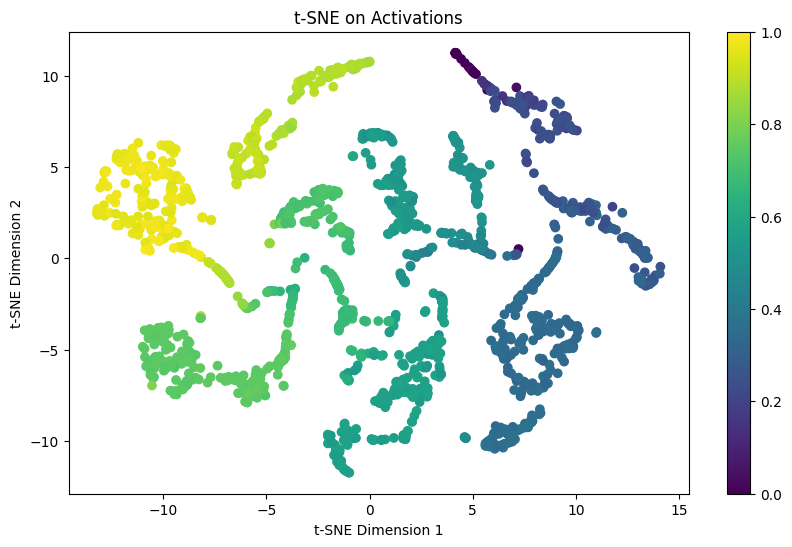

In [ ]:
# Perform t-SNE
from sklearn.manifold import TSNE

# Create t-SNE instance
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

# Fit t-SNE to your activations data
tsne_result = tsne.fit_transform(activations)

# plot t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels_list[:, 0], cmap='viridis')
plt.colorbar()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE on Activations')
plt.show()
